**<h1>Lamoda reviews dataset**

## Сервисные классы и функции

### Подключение необходимых библиотек

In [ ]:
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from tqdm import tqdm
from razdel import tokenize
from navec import Navec

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, BertModel

### Класс загрузки файла и информация о нем

In [ ]:
class Import_file:
        """
        Args:
            file_path (str): Путь до обрабатываемого файла
        """
        def __init__(self, file_path: str) -> None:
              self.file_path = file_path

              self.data = pd.read_csv(rf"{self.file_path}")
              self.data = self.data.astype("U")

        def show_imported_df(self, view_rows: int = 0):
            print(self.data.head(view_rows))
            print(f"\nРазмер вашего файла: {self.data.shape}")

            # Подсчёт количества примеров для каждого класса
            class_counts = self.data['sentiment'].value_counts()

            # Построение диаграммы примеров для каждого класса
            plt.figure(figsize=(8, 6))
            class_counts.plot(kind='bar', color=['red', 'green', 'blue'])
            plt.title('Количество примеров для каждого класса')
            plt.xlabel('Класс')
            plt.ylabel('Количество примеров')
            plt.xticks(rotation=0)
            plt.show()

            # Визуализация пропусков
            plt.figure(figsize=(10, 6))
            sns.heatmap(self.data.isnull(), cbar=False, cmap='viridis')
            plt.title('Пропуски в столбце review')
            plt.show()

        def show_another_df(self, df: pd.DataFrame, view_rows: int = 0):
            print(df.head(view_rows))
            print(f"\nРазмер вашего файла: {df.shape}")

            # Подсчёт количества примеров для каждого класса
            class_counts = df['sentiment'].value_counts()

            # Построение диаграммы примеров для каждого класса
            plt.figure(figsize=(8, 6))
            class_counts.plot(kind='bar', color=['red', 'green', 'blue'])
            plt.title('Количество примеров для каждого класса')
            plt.xlabel('Класс')
            plt.ylabel('Количество примеров')
            plt.xticks(rotation=0)
            plt.show()

            # Визуализация пропусков
            plt.figure(figsize=(10, 6))
            sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
            plt.title('Пропуски в столбце review')
            plt.show()

### Класс предобработки файла

In [ ]:
class Cleaning_file:
        """
        Args:
            file_path (str): Путь до обрабатываемого файла
        """

        def __init__(self, file_path: str) -> None:
            self.file_path = file_path
            self.data = pd.read_csv(file_path)
            # Инициализация необходимых компонентов для проведения лемматизации
            self.segmenter = Segmenter()
            self.morph_vocab = MorphVocab()
            self.emb = NewsEmbedding()
            self.morph_tagger = NewsMorphTagger(self.emb)

        # Функция для лемматизации текста на русском языке с обработкой None
        def lemmatize_text(self, text: str) -> str:
            if text is None or text.strip() == '':
                return 'none'

            try:
                doc = Doc(text)
                doc.segment(self.segmenter)
                doc.tag_morph(self.morph_tagger)

                lemmatized_words = []
                for token in doc.tokens:
                    token.lemmatize(self.morph_vocab)
                    lemmatized_words.append(token.lemma)

                return ' '.join(lemmatized_words)
            except Exception as e:
                print(f"Error processing text: {text}, Error: {e}")
                return 'none'

        def preprocessing(self):
            self.data['review'] = self.data['review'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' ').replace("   ", " ").replace("  ", " ").strip(" "))
            self.data['review'] = self.data['review'].apply(lambda x: x.lower().strip())
            self.data['review'] = self.data['review'].apply(lambda x: re.sub(r'[^a-zA-Zа-яА-Яё\s]', ' ', x))
            self.data['review'] = self.data['review'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' ').replace("   ", " ").replace("  ", " ").strip(" "))
            self.data['review'] = self.data['review'].apply(self.lemmatize_text)

        def save_file(self, path):
            self.data.to_csv(f"{path}", index=False)

### Класс создания выборок для подачи в нейронную сеть

In [ ]:
class File_sampling:

    def __init__(self, file_path: str):
        self.data = pd.read_csv(f"{file_path}")
        self.x_data = ""
        self.y_data = ""
        self.x_train = ""
        self.y_train = ""
        self.x_test = ""
        self.y_test = ""
        # Создание списка классов
        self.class_labels = ['negative', 'positive', 'neutral']

        # Загрузка предобученной модели BERT и токенизатора
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-cased')

    # Преобразование текстов в эмбеддинги
    def __encode_text(self, text, tokenizer, model):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Используем эмбеддинг [CLS] токена в качестве представления текста
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        return cls_embedding

    # Векторизация текстов и приведение целевого столбца в OHE
    def vectorizing(self):
        # Разделение данных на x_datas и y_datas
        x_datas = pd.DataFrame(self.data['review']).astype(dtype='U')
        y_datas = self.data['sentiment']

        # Преобразование меток в формат OHE
        encoder = OneHotEncoder(sparse_output=False)
        y_data_ohe = encoder.fit_transform(y_datas.values.reshape(-1, 1))
        self.y_data = y_data_ohe

        # Применение функции векторизации к каждому тексту
        x_data_vectorized = np.array([self.__encode_text(text, self.tokenizer, self.model) for text in tqdm(x_datas['review'])])
        self.x_data = x_data_vectorized

    def delimiter(self, test_size: float, stratify: bool):
        if stratify:
            # Разделение данных на обучающую и тестовую выборки с стратификацией
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x_data, self.y_data, test_size=test_size, stratify=self.y_data, random_state=42)
        else:
            # Разделение данных на обучающую и тестовую выборки без стратификации
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x_data, self.y_data, test_size=test_size, random_state=42)

    def save_arrays_from_delimitering(self, files_directory: str):
        np.save(f'{files_directory}/x_train.npy', self.x_train)
        np.save(f'{files_directory}/y_train.npy', self.y_train)
        np.save(f'{files_directory}/x_test.npy', self.x_test)
        np.save(f'{files_directory}/y_test.npy', self.y_test)

### Сервисная функция для работы с моделью и вывода результатов

In [ ]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    callback = EarlyStopping(monitor='val_accuracy', patience=50)

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[callback])

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)#Целочисленные координаты оси абсцисс установлены
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    plt.style.use('default')
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

    model.save(f"{title}.h5")

class_labels = ['negative', 'positive', 'neutral']

# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=class_labels,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### Класс для тестирования модели

In [ ]:
import joblib


class Testing_Model:
    def __init__(self, model_path: str, prompt: str) -> None:
        self.model = self.load_model(model_path)
        self.prompt = prompt
        self.encoded_text = np.array([])

        # Инициализация необходимых компонентов для проведения лемматизации
        self.segmenter = Segmenter()
        self.morph_vocab = MorphVocab()
        self.emb = NewsEmbedding()
        self.morph_tagger = NewsMorphTagger(self.emb)

        # Создание списка классов
        self.class_labels = ['negative', 'positive', 'neutral']

        # Загрузка предобученной модели BERT и токенизатора
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

    # Метод для загрузки модели классификации
    def load_model(self, model_path: str):
        # Загрузка модели Keras
        classifier = load_model(model_path)
        return classifier

    # Функция для лемматизации текста на русском языке с обработкой None
    def lemmatize_text(self, text: str) -> str:
        if text is None or text.strip() == '':
            return 'none'

        try:
            doc = Doc(text)
            doc.segment(self.segmenter)
            doc.tag_morph(self.morph_tagger)

            lemmatized_words = []
            for token in doc.tokens:
                token.lemmatize(self.morph_vocab)
                lemmatized_words.append(token.lemma)

            return ' '.join(lemmatized_words)
        except Exception as e:
            print(f"Error processing text: {text}, Error: {e}")
            return 'none'

    def preprocessing(self):
        self.prompt = (self.prompt).replace('\n', ' ').replace('\r', ' ').replace("   ", " ").replace("  ", " ").strip(" ")
        self.prompt = (self.prompt).lower().strip()
        self.prompt = re.sub(r'[^a-zA-Zа-яА-Яё\s]', ' ', self.prompt)
        self.prompt = (self.prompt).replace('\n', ' ').replace('\r', ' ').replace("   ", " ").replace("  ", " ").strip(" ")
        self.prompt = self.lemmatize_text(self.prompt)

    # Преобразование текстов в эмбеддинги
    def encode_text(self):
        inputs = self.tokenizer(self.prompt, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        # Используем эмбеддинг [CLS] токена в качестве представления текста
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        self.encoded_text = cls_embedding

    # Функция для предсказания класса текста
    def predict_text(self):
        # Векторизация текста
        text_vector = self.encoded_text
        text_vector = np.expand_dims(text_vector, axis=0)  # Добавление размерности для батча

        # Предсказание класса
        prediction = self.model.predict(text_vector)
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Интерпретация предсказания
        predicted_label = self.class_labels[predicted_class]
        return predicted_label

## Подготовка данных

In [ ]:
data_imported = Import_file(
    file_path="D:/Projects/Final_work/women_clothing_accessories_normalized.csv"
)
data_cleaning = Cleaning_file(
    file_path="D:/Projects/Final_work/women_clothing_accessories_normalized.csv",
)

                                               review sentiment
0   качество плохое пошив ужасный (горловина напер...  negative
1   Товар отдали другому человеку, я не получила п...  negative
2   Ужасная синтетика! Тонкая, ничего общего с пре...  negative
3   товар не пришел, продавец продлил защиту без м...  negative
4       Кофточка голая синтетика, носить не возможно.  negative
5                               Очень глубокие проймы  negative
6   Я недовольна заказом.Я вот одного не понимаю п...  negative
7   заказала размер s на от 64, об 94, начнем с то...  negative
8   Заказ я сделала в июле. С тех пор посылка отсл...  negative
9                            Ужасное качество товара!  negative
10  короткая кофта нитки торчат,не суразно выгляди...  negative
11         ткань приятная. вот только пятно на спине.  negative
12  рубашка очень маломерит .. заказывала хл пришл...  negative
13  кофта пришла с браком, вот такая дыра на горло...  negative
14  товар застрял во Внуково. видимо кар

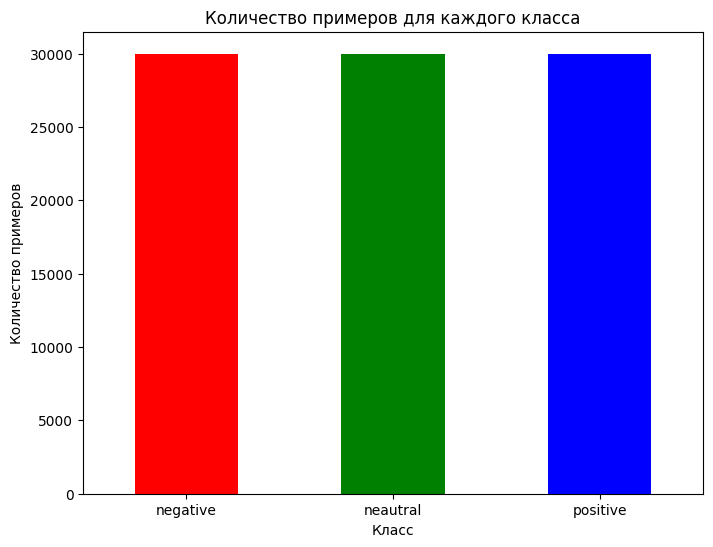

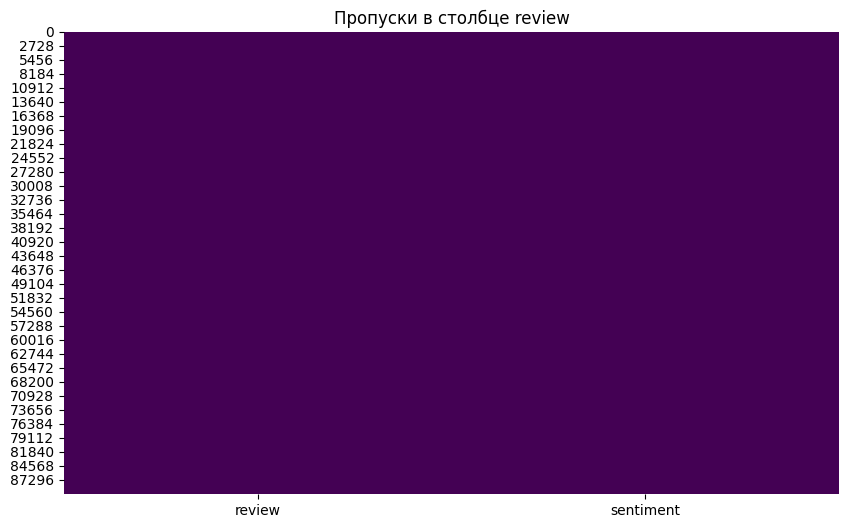

In [ ]:
data_imported.show_imported_df(15)

                                               review sentiment
0   качество плохой пошив ужасный горловина напере...  negative
1   товар отдать другой человек я не получить посы...  negative
2   ужасный синтетика тонкий ничто общий с предста...  negative
3   товар не прийти продавец продлить защита без м...  negative
4        кофточка голый синтетика носить не возможный  negative
5                               очень глубокий пройма  negative
6   я недовольный заказ я вот один не понимать поч...  negative
7   заказать размер s на от о начать с тот что вле...  negative
8   заказ я сделать в июль с тот пора посылка отсл...  negative
9                              ужасный качество товар  negative
10  короткий кофта нитка торчать не суразный выгля...  negative
11           ткань приятный вот только пятно на спина  negative
12  рубашка очень маломерить заказывать хл прийти ...  negative
13    кофта прийти с брак вот такой дыра на горловина  negative
14  товар застрять в внуково видимо каря

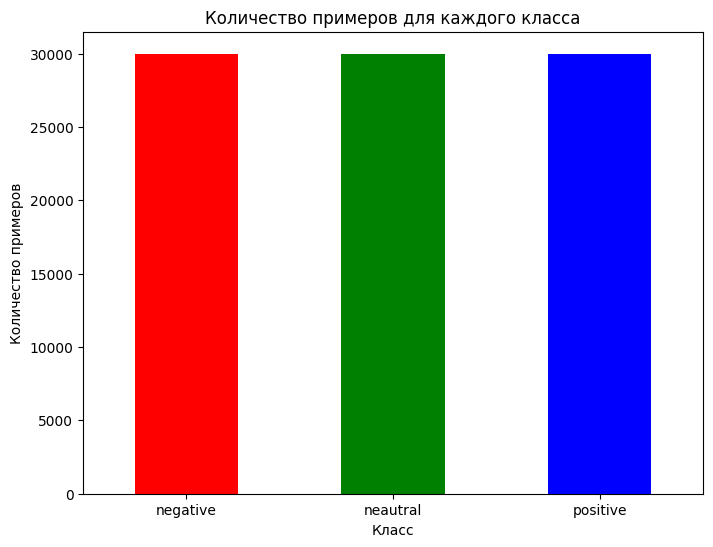

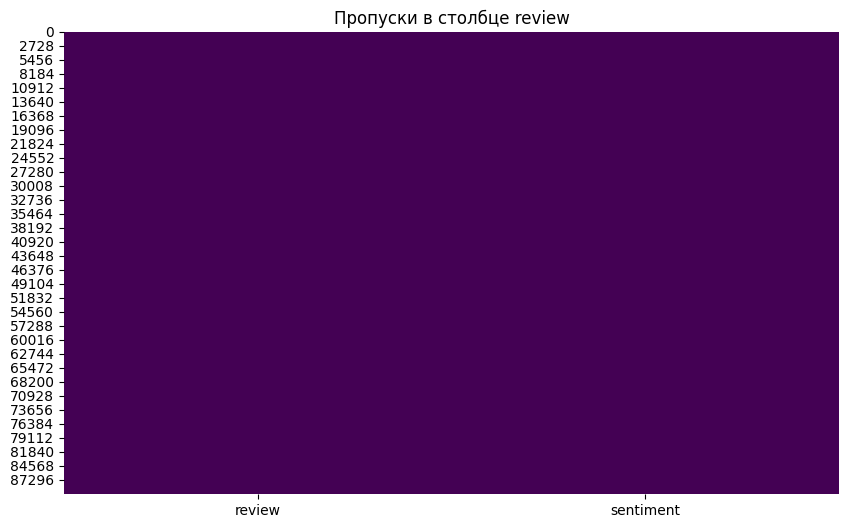

In [ ]:
data_cleaning.preprocessing()
data_imported.show_another_df(data_cleaning.data, 50)
data_cleaning.save_file("D:/Projects/Final_work/datalemm.csv")

### Получение выборок

In [ ]:
data_delimetering = File_sampling(
    file_path="D:/Projects/Final_work/datalemm.csv"
)
data_delimetering.vectorizing()
data_delimetering.delimiter(test_size=0.2, stratify=True)
data_delimetering.save_arrays_from_delimitering(files_directory="D:/Projects/Final_work")

100%|██████████| 90000/90000 [1:24:48<00:00, 17.69it/s]


In [ ]:
x_train = data_delimetering.x_train
y_train = data_delimetering.y_train
x_test = data_delimetering.x_test
y_test = data_delimetering.y_test

class_labels = data_delimetering.class_labels
print(class_labels)

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

['negative', 'positive', 'neutral']
x_train.shape: (72000, 768)
y_train.shape: (72000, 3)
x_test.shape: (18000, 768)
y_test.shape: (18000, 3)


## Получение модели

In [ ]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

c:\Users\gioca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,867 (2.17 MB)

 Trainable params: 568,867 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.3441 - loss: 1.1127 - val_accuracy: 0.5604 - val_loss: 0.9342
Epoch 2/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.5553 - loss: 0.9188 - val_accuracy: 0.6161 - val_loss: 0.8391
Epoch 3/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.6156 - loss: 0.8350 - val_accuracy: 0.6378 - val_loss: 0.7993
Epoch 4/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.6298 - loss: 0.8100 - val_accuracy: 0.6108 - val_loss: 0.7983
Epoch 5/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.6385 - loss: 0.7944 - val_accuracy: 0.6313 - val_loss: 0.7850
Epoch 6/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.6422 - loss: 0.7850 - val_accuracy: 0.6363 - val_loss: 0.7904
Epoch 7/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.6490 - loss: 0.7726 - val_accuracy: 0.6261 - val_loss: 0.7981
Epoch 8/3000
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/s

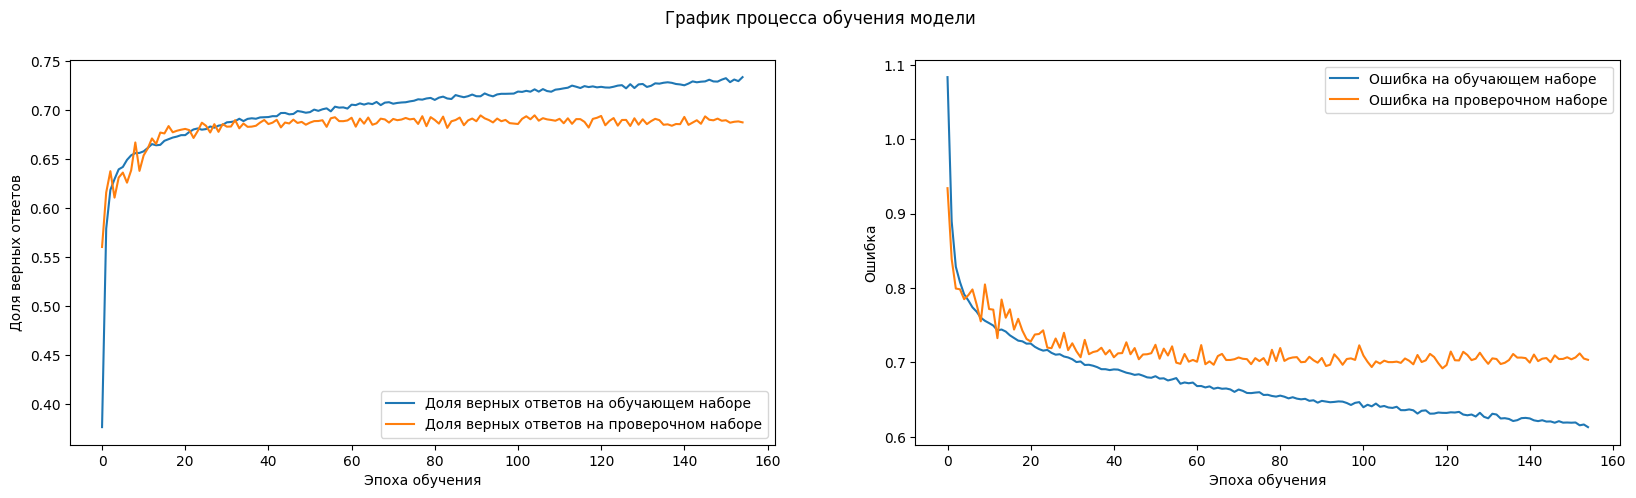

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


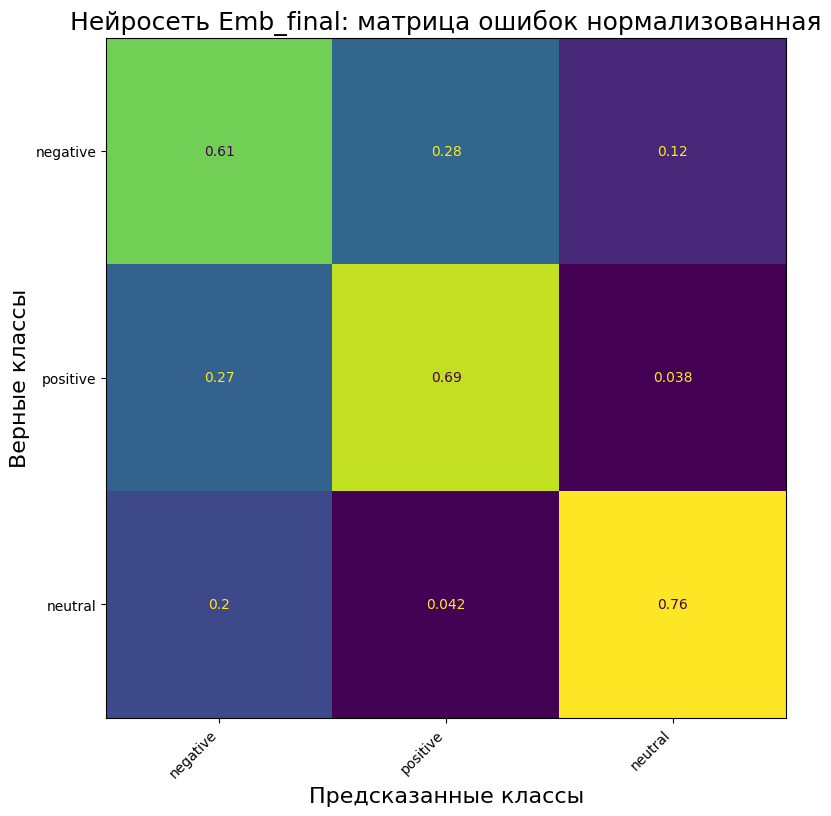

----------------------------------------------------------------------------------------------------
Нейросеть: Emb_final
Класс: negative              61% сеть отнесла к классу negative             - ВЕРНО :-)
Класс: positive              70% сеть отнесла к классу positive             - ВЕРНО :-)
Класс: neutral               76% сеть отнесла к классу neutral              - ВЕРНО :-)

Средняя точность распознавания:  69%


In [ ]:
# Создание модели
model = Sequential()

model.add(Dense(512, input_dim=768, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dense(3, activation='softmax'))

# Входные данные подаются в виде векторов
compile_train_eval_model(model,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=class_labels,
                         title='Emb_final',
                         optimizer=Adam(learning_rate=0.0001),
                         epochs=3000,
                         batch_size=4)

**<h2>Итог:</h2>**

|Model|Total params|Trainable params|Non-trainable params|Accuracy|Accuracy from classes|
|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
|Emb-final.h5|568,867 (2.17 MB)|568,867 (2.17 MB)|0 (0.00 B)|69%|61/70/76|

Исходя из этих данных видно, что меньший процент распозавания именно негативного класса, но по требованию заказчика, результат замечательный.

Согласно ТЗ заказчика, было основное требование - достижение точности более 50% из-за не сбалансированности данных.

Не сбалансированность данных заключается в наличии отзывов на 4 разных языках и транслите (русский текст, английскими буквами). Поэтому результат отличный.

Далее когда заказчик предоставит датасет с размером (от 30000 отзывов на каждом языке, эксперимент продолжится, для этого заказчику, по его мнению, потребуется, от 16 до 23 месяцев)


Подведя итог: Результат оказался превосходящим ожидания заказчика и цель достигнута


## Тестирование модели

Негативный сценарий

In [ ]:
some_text = "Ужасная вещь, воняет как гавно!"

ts = Testing_Model(
    model_path="D:/Projects/Final_work/Emb_final.h5",
    prompt=some_text
)

ts.preprocessing()
ts.encode_text()
predicted_label = ts.predict_text()

print(ts.prompt)
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
ужасный вещь вонять как гавный
negative


Нейтральный сценарий

In [ ]:
some_text = "нормально, устраивает"

ts = Testing_Model(
    model_path="D:/Projects/Final_work/Emb_final.h5",
    prompt=some_text
)

ts.preprocessing()
ts.encode_text()
predicted_label = ts.predict_text()

print(ts.prompt)
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
нормально устраивать
neutral


Отличный сценарий

In [ ]:
some_text = "five, best quallity"

ts = Testing_Model(
    model_path="D:/Projects/Final_work/Emb_final.h5",
    prompt=some_text
)

ts.preprocessing()
ts.encode_text()
predicted_label = ts.predict_text()

print(ts.prompt)
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
five best quallity
positive
